# Assignment 2 - Basic Machine Learning to predict Pokémon battles results

([From Wikipedia](https://en.wikipedia.org/wiki/Pok%C3%A9mon)) *Pokémon is a Japanese media franchise managed by The Pokémon Company, a company founded by Nintendo, Game Freak, and Creatures. The franchise was created by Satoshi Tajiri in 1996,[4] and is centered on fictional creatures called "Pokémon". In Pokémon, humans, known as Pokémon Trainers, catch and train Pokémon to battle other Pokémon for sport.*

In this assignment we present you a dataset with the results of several Pokémon battles.

Your objective will be to produce a ML model that can predict the outcomes of any Pokémon battle.

At first, in this notebook, you will apply some of the basic ML approaches that we have seen in class. At this point you can also work with the *small* versions of the dataset if you want.

Later, on the `pokemon-competition.ipynb` notebook, you will train a model using all the data that will be used to predict *real* Pokémon battles.

**Dataset Description**

Within the `datasets.zip` file that you can download from the virtual campus, you will find the following datasets:

- data.train -> Full data available to train the models
- data_inverse.train -> Same data as data.train but each combat is seen from the other player's perspective (i.e. pokemon1 becomes pokemon2 and viceversa)
- small.train -> Subsample of data.train to allow fast prototyping
- small_inverse.train -> Subsample of data_inverse.train to allow fast prototyping
- data.hidden -> Dataset with no label available
- data_inverse.hidden -> Same as data.hidden but the pokemons are inverted

The datasets *.hidden are the ones used to get the tournament score,
so the true label is unknown. All the other datasets are available to
you to use however you want.

*Gotta Train 'Em All!*

In [1]:
from pathlib import Path
import pandas

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pandas.read_csv(datasets_path / "data.train", index_col=0)
inverse_data = pandas.read_csv(datasets_path / "data.train", index_col=0)

def get_Xy(dataset):
    return dataset.drop("Wins", axis=1), dataset["Wins"]

X, y = get_Xy(data)

In [2]:
# Add your imports here
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
# Additional settings
pandas.set_option('display.max_columns', None)

## Part 1 - Analyze the dataset (2 points)
The first step of any ML process is to know the data we are dealing with. In this part, you have to analyze the dataset and answer the questions below.

1. Which features are categorical? Which are continuous?

In [4]:
# Dataset General Data
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               36006 non-null  object 
 1   Type 1             36026 non-null  object 
 2   Type 2             19465 non-null  object 
 3   HP                 35994 non-null  float64
 4   Attack             36103 non-null  float64
 5   Defense            35966 non-null  float64
 6   Sp. Atk            36080 non-null  float64
 7   Sp. Def            36018 non-null  float64
 8   Speed              36028 non-null  float64
 9   Generation         36007 non-null  float64
 10  Legendary          36019 non-null  object 
 11  Name__other        36037 non-null  object 
 12  Type 1__other      35990 non-null  object 
 13  Type 2__other      19406 non-null  object 
 14  HP__other          35895 non-null  float64
 15  Attack__other      36005 non-null  float64
 16  Defense__other    

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Name__other,Type 1__other,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other,Legendary__other,Wins
39087,Karrablast,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,5.0,False,Pidove,Normal,NaN,50.0,53.0,43.0,47.0,27.0,40.0,5.0,False,True
30893,NaN,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,1.0,False,Tepig,Fire,NaN,65.0,64.0,NaN,49.0,41.0,39.0,5.0,False,True
45278,Mega Manectric,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,3.0,NaN,Garbodor,Poison,NaN,NaN,48.0,78.0,NaN,83.0,75.0,5.0,False,True
16398,Bouffalant,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,5.0,False,Tauros,Normal,NaN,75.0,108.0,101.0,39.0,68.0,106.0,NaN,False,False
13653,Swablu,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,3.0,False,Mr. Mime,Psychic,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,1.0,False,False
13748,NaN,Water,Fairy,100.0,57.0,87.0,67.0,80.0,51.0,2.0,True,Prinplup,Water,NaN,64.0,66.0,67.0,78.0,84.0,50.0,4.0,False,False
23965,Kingler,Water,NaN,55.0,131.0,118.0,51.0,54.0,58.0,1.0,False,NaN,Fighting,Psychic,60.0,61.0,78.0,63.0,NaN,78.0,3.0,False,False
45552,Mega Diancie,Rock,Fairy,50.0,154.0,109.0,164.0,105.0,106.0,6.0,True,Politoed,Water,NaN,90.0,75.0,76.0,84.0,102.0,70.0,2.0,False,True
30219,Chespin,Grass,NaN,56.0,54.0,72.0,55.0,50.0,NaN,NaN,False,Primal Kyogre,Water,NaN,92.0,154.0,86.0,NaN,154.0,81.0,3.0,True,False
24079,Volcanion,NaN,Water,80.0,110.0,NaN,132.0,NaN,74.0,6.0,True,Vigoroth,Fairy,NaN,90.0,117.0,79.0,62.0,59.0,44.0,2.0,NaN,True


In [5]:
# Categorical Data
categorical_df = data[['Name','Type 1','Type 2','Generation','Legendary','Name__other','Type 1__other','Type 2__other','Generation__other','Legendary__other','Wins']]
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               36006 non-null  object 
 1   Type 1             36026 non-null  object 
 2   Type 2             19465 non-null  object 
 3   Generation         36007 non-null  float64
 4   Legendary          36019 non-null  object 
 5   Name__other        36037 non-null  object 
 6   Type 1__other      35990 non-null  object 
 7   Type 2__other      19406 non-null  object 
 8   Generation__other  36014 non-null  float64
 9   Legendary__other   36018 non-null  object 
 10  Wins               40000 non-null  bool   
dtypes: bool(1), float64(2), object(8)
memory usage: 3.4+ MB


In [6]:
# Continuous Data
continuous_df = data[['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','HP__other','Attack__other','Defense__other','Sp. Atk__other','Sp. Def__other','Speed__other']]
continuous_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HP              35994 non-null  float64
 1   Attack          36103 non-null  float64
 2   Defense         35966 non-null  float64
 3   Sp. Atk         36080 non-null  float64
 4   Sp. Def         36018 non-null  float64
 5   Speed           36028 non-null  float64
 6   HP__other       35895 non-null  float64
 7   Attack__other   36005 non-null  float64
 8   Defense__other  35984 non-null  float64
 9   Sp. Atk__other  35904 non-null  float64
 10  Sp. Def__other  35995 non-null  float64
 11  Speed__other    35956 non-null  float64
dtypes: float64(12)
memory usage: 4.0 MB


2. Observe the distribution of the "Type 1" variable. Use a plot to show this distribution.

<AxesSubplot:>

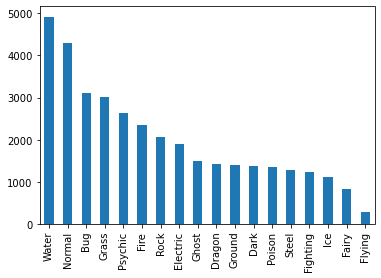

In [7]:
data['Type 1'].value_counts().plot(kind='bar')

3. Determine which of the features have missing values. How many missing values there are for each one?

In [8]:
# Columns with missing values
list(data.columns[data.isnull().any()])

['Name',
 'Type 1',
 'Type 2',
 'HP',
 'Attack',
 'Defense',
 'Sp. Atk',
 'Sp. Def',
 'Speed',
 'Generation',
 'Legendary',
 'Name__other',
 'Type 1__other',
 'Type 2__other',
 'HP__other',
 'Attack__other',
 'Defense__other',
 'Sp. Atk__other',
 'Sp. Def__other',
 'Speed__other',
 'Generation__other',
 'Legendary__other']

In [9]:
# Count Missing Values for each column
data.isnull().sum()

Name                  3994
Type 1                3974
Type 2               20535
HP                    4006
Attack                3897
Defense               4034
Sp. Atk               3920
Sp. Def               3982
Speed                 3972
Generation            3993
Legendary             3981
Name__other           3963
Type 1__other         4010
Type 2__other        20594
HP__other             4105
Attack__other         3995
Defense__other        4016
Sp. Atk__other        4096
Sp. Def__other        4005
Speed__other          4044
Generation__other     3986
Legendary__other      3982
Wins                     0
dtype: int64

4. Analize the distribution of the target column. Is it balanced?

<AxesSubplot:>

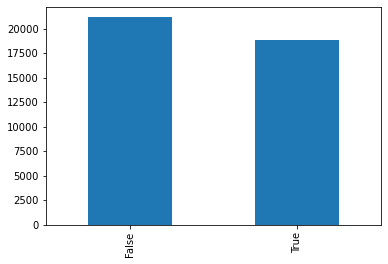

In [10]:
data['Wins'].value_counts().plot(kind='bar')

As we can see in the bar plot, the target column is well-balanced because all the the different values (in our case true or false) have more or less the same quantity. The distribution of the different values is well equilibrated.

## Part 2 - Preprocess the data (3 points)
Once we know how the dataset is, we can proceed with the cleaning of the data. This includes:

- Select the features that you want to use (p.e. removing too specific features). Explain why each feature is used or discarded.
- Impute the missing values. Explain why you use this imputer and not another one. If you use different imputers for different features, explain the reason why you do this.
- Encode the values of the features to work with the model you choose. This can be either encoding the categorical values, or discretizing continuous values.

In [11]:
# Data
processing_df = data

In [12]:
# Note:
# Drop rows with missing values with too much data is also dangerous. It can 
# create significant bias by depriving your algorithms of space. This is specially true of classifiers sensitive 
# to the curse of dimensionality. In our case we start with 40.000 rows and if we clean it, we have more or less
# 1400 rows, it means that we lose a lot information.

# Encode Categorical Variables: Booleans (False = 0, True = 1) 

processing_df['Wins'] = processing_df['Wins'].astype('Int64')
processing_df['Legendary__other'] = processing_df['Legendary__other'].map({False:0,True:1})
processing_df['Legendary'] = processing_df['Legendary'].map({False:0,True:1})

In [13]:
# Encode Categorical Data : Strings
# https://scikit-learn.org/stable/modules/preprocessing.html
# https://stackoverflow.com/questions/54444260/labelencoder-that-keeps-missing-values-as-nan

label_to_encode_name = ['Name','Name__other']
label_to_encode_type = ['Type 1','Type 2','Type 1__other','Type 2__other']

label_encoder_name = LabelEncoder()
label_encoder_type = LabelEncoder()

# Encode Pokemon Names
processing_df[label_to_encode_name] = processing_df[label_to_encode_name].apply(lambda series: pandas.Series(
    label_encoder_name.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

# Encode Pokemon Types
processing_df[label_to_encode_type] = processing_df[label_to_encode_type].apply(lambda series: pandas.Series(
    label_encoder_type.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

print(label_encoder_name.classes_[:10])
print(label_encoder_type.classes_[:10])

['Abomasnow' 'Abra' 'Absol' 'Accelgor' 'Aegislash Blade Forme'
 'Aegislash Shield Forme' 'Aerodactyl' 'Aggron' 'Aipom' 'Alakazam']
['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass']


In [14]:
# Imputation Data

# A) Simple imputation
# imp_num = SimpleImputer(strategy='mean')
# imp_cat = SimpleImputer(strategy='most_frequent')

# B) Iterative Imputer
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
    
# imp_num = IterativeImputer(estimator=RandomForestRegressor(),
#                            initial_strategy='mean',
#                            max_iter=1, random_state=0)

# imp_cat = IterativeImputer(estimator=RandomForestClassifier(), 
#                            initial_strategy='most_frequent',
#                            max_iter=1, random_state=0)

# categorical = list(categorical_df.columns)
# categorical.remove('Wins')
# numerical = continuous_df.columns

# processing_df[numerical] = imp_num.fit_transform(processing_df[numerical])
# processing_df[categorical] = imp_cat.fit_transform(processing_df[categorical])

# C) Impute Missing Values using KNN
# Imputation for completing missing values using k-Nearest Neighbors.
# https://stackoverflow.com/questions/64900801/implementing-knn-imputation-on-categorical-variables-in-an-sklearn-pipeline
# https://towardsdatascience.com/going-beyond-the-simpleimputer-for-missing-data-imputation-dd8ba168d505

knn_imputer = KNNImputer(n_neighbors=1) # n_neighbors=1 avoid mean/average values
processing_df = knn_imputer.fit_transform(processing_df)
processing_df = pandas.DataFrame(processing_df,columns=data.columns)

processing_df.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Name__other,Type 1__other,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other,Legendary__other,Wins
0,314.0,0.0,1.0,50.0,72.0,39.0,39.0,42.0,55.0,5.0,0.0,521.0,12.0,7.0,50.0,53.0,43.0,47.0,27.0,40.0,5.0,0.0,1.0
1,736.0,15.0,17.0,70.0,83.0,125.0,113.0,78.0,55.0,1.0,0.0,689.0,6.0,17.0,65.0,64.0,50.0,49.0,41.0,39.0,5.0,0.0,1.0
2,425.0,3.0,7.0,70.0,77.0,81.0,65.0,91.0,136.0,3.0,0.0,222.0,13.0,7.0,60.0,48.0,78.0,110.0,83.0,75.0,5.0,0.0,1.0
3,58.0,14.0,7.0,95.0,121.0,75.0,39.0,85.0,94.0,5.0,0.0,685.0,12.0,13.0,75.0,108.0,101.0,39.0,68.0,106.0,6.0,0.0,0.0
4,671.0,12.0,7.0,45.0,36.0,58.0,37.0,76.0,56.0,3.0,0.0,470.0,14.0,4.0,40.0,46.0,68.0,108.0,123.0,86.0,1.0,0.0,0.0


IterativeImputer actually builds a regression model iteratively by using subsets of the columns to predict the missing values. kNNImputer is also a multivariate approach however it uses kNN which would average the features based on some distance metric (usually Euclidean).

The kNNImputer could do better and could be faster than Iterative Imputer when the dimension of the dataset is high. It is because Iterative Imputer runs regression on a bunch of combinations of many columns then it will take a lot of time.

We decide to use KNN imputer because it follows the k-Nearest Neighbors method to replace the missing values in the datasets with the mean value from the parameter ‘n_neighbors’ (we only use one neighbor to avoid the mean values) nearest neighbors found in the training set. By default, it uses a Euclidean distance metric to impute the missing values.

One thing to note here is that the KNN Imputer does not recognize text data values, and for this reason we decide to encode data before.

In [15]:
# Reduce dimension of the dataset
processing_df = processing_df.drop(columns=['Legendary', 'Legendary__other','Generation','Generation__other','Type 2','Type 2__other'])
processing_df.info()
processing_df.head(20)

# Legendary variable defines the rarity to find this Pokemon. Therefore, doesn't affect the victory of the battle.
# Generation variable defines the seasson that the Pokemon appears.
# Type_1 of the Pokemon define the weak/strong over the other pokemon type.
# Type_2 is descarted because it has 50% missing values
# All the continuous variables are important to predict the battle.
# Wins variable is obviously required to develop the supervised prediction.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            40000 non-null  float64
 1   Type 1          40000 non-null  float64
 2   HP              40000 non-null  float64
 3   Attack          40000 non-null  float64
 4   Defense         40000 non-null  float64
 5   Sp. Atk         40000 non-null  float64
 6   Sp. Def         40000 non-null  float64
 7   Speed           40000 non-null  float64
 8   Name__other     40000 non-null  float64
 9   Type 1__other   40000 non-null  float64
 10  HP__other       40000 non-null  float64
 11  Attack__other   40000 non-null  float64
 12  Defense__other  40000 non-null  float64
 13  Sp. Atk__other  40000 non-null  float64
 14  Sp. Def__other  40000 non-null  float64
 15  Speed__other    40000 non-null  float64
 16  Wins            40000 non-null  float64
dtypes: float64(17)
memory usage: 5.

,Name,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Name__other,Type 1__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Wins
0,314.0,0.0,50.0,72.0,39.0,39.0,42.0,55.0,521.0,12.0,50.0,53.0,43.0,47.0,27.0,40.0,1.0
1,736.0,15.0,70.0,83.0,125.0,113.0,78.0,55.0,689.0,6.0,65.0,64.0,50.0,49.0,41.0,39.0,1.0
2,425.0,3.0,70.0,77.0,81.0,65.0,91.0,136.0,222.0,13.0,60.0,48.0,78.0,110.0,83.0,75.0,1.0
3,58.0,14.0,95.0,121.0,75.0,39.0,85.0,94.0,685.0,12.0,75.0,108.0,101.0,39.0,68.0,106.0,0.0
4,671.0,12.0,45.0,36.0,58.0,37.0,76.0,56.0,470.0,14.0,40.0,46.0,68.0,108.0,123.0,86.0,0.0
5,258.0,17.0,100.0,57.0,87.0,67.0,80.0,51.0,540.0,17.0,64.0,66.0,67.0,78.0,84.0,50.0,0.0
6,319.0,17.0,55.0,131.0,118.0,51.0,54.0,58.0,120.0,5.0,60.0,61.0,78.0,63.0,60.0,78.0,0.0
7,412.0,15.0,50.0,154.0,109.0,164.0,105.0,106.0,529.0,17.0,90.0,75.0,76.0,84.0,102.0,70.0,1.0
8,91.0,9.0,56.0,54.0,72.0,55.0,50.0,61.0,538.0,17.0,92.0,154.0,86.0,180.0,154.0,81.0,0.0
9,740.0,6.0,80.0,110.0,65.0,132.0,91.0,74.0,735.0,4.0,90.0,117.0,79.0,62.0,59.0,44.0,1.0


## Part 3 - Training your model (3 points)
In this part you have to train a **classifier** model to predict if a Pokemon will win or not a battle against another Pokemon. For this, you should explore at least 3 different classifiers.

You have to train and evaluate those classifiers using cross-validation in order to select the best one. Then, you should also study the results of the model (overfit, underfit, possible bias...).

1. Train (at least) 3 different classifiers
2. Evaluate the 3 classifiers using cross-validation. Select the best model according to this metric.
3. For the selected model: 
   1. Get the accuracy for data not seen during the training process
   2. Plot the confusion matrix
   3. Analize the results of accuracy and the confusion matrix

In [16]:
X, y = get_Xy(processing_df) # X = features , y = target (Win/Loss)

# y = y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

In [17]:
# Cross Validation : https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators

# Classifier A: Naive Bayes
# https://scikit-learn.org/stable/modules/naive_bayes.html
# https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

# Cross Validation
scores = cross_val_score(gnb, X_train, y_train, cv=10) # 10 Folds
print(f"Naive Bayes Scores: {scores}\n")
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}\n")

gnb_y_pred = gnb.fit(X_train, y_train).predict(X_test) # Fit the model &  Predict the response of the dataset

Naive Bayes Scores: [0.760625 0.76875  0.783125 0.73375  0.766875 0.76625  0.753125 0.75
 0.755625 0.765   ]

0.7603125 accuracy with a standard deviation of 0.012560012191474963



As we can see the results of cross-validation, it shows that this algorithm has overfiting in some cases because it captures some noise that means it "missed the point".

In [18]:
# Classifier B: Neuronal Network MLPClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(random_state=1, max_iter=300)

# Cross Validation
scores = cross_val_score(nn, X_train, y_train, cv=10)
print(f"Neuronal Network MLPClassifier Scores: {scores}\n")
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}\n")

nn_y_pred = nn.fit(X_train, y_train).predict(X_test)

Neuronal Network MLPClassifier Scores: [0.80375  0.811875 0.78125  0.7775   0.78     0.82     0.81875  0.8075
 0.816875 0.78    ]

0.79975 accuracy with a standard deviation of 0.017043602172076174



As we can see the results of cross-validation, it shows that this algorithm has overfiting in some cases because it captures some noise that means it "missed the point".

In [19]:
# Classifier C: Nearest Neighbors Classification
# https://scikit-learn.org/stable/modules/neighbors.html

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

# Cross Validation
scores = cross_val_score(neigh, X_train, y_train, cv=10)
print(f"Nearest Neighbors Classification Scores: {scores}\n")
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}\n")

neigh_y_pred = neigh.fit(X_train, y_train).predict(X_test)

Nearest Neighbors Classification Scores: [0.720625 0.729375 0.743125 0.720625 0.72875  0.721875 0.724375 0.726875
 0.720625 0.73375 ]

0.7270000000000001 accuracy with a standard deviation of 0.006851094803022379



As we can see the results of cross-validation, it shows that this algorithm has underfiting in some cases because it has high loss for instance in the value 0.70625 to the value 0.66875.

In [20]:
# Classifier D: Decision Trees
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)

# Cross Validation
scores = cross_val_score(tree, X_train, y_train, cv=10)
print(f"Decision Trees Scores: {scores}\n")
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}\n")

tree_y_pred = tree.fit(X_train, y_train).predict(X_test)

Decision Trees Scores: [0.770625 0.75625  0.77875  0.75     0.748125 0.748125 0.739375 0.75125
 0.7525   0.779375]

0.7574375 accuracy with a standard deviation of 0.013147153922047171



As we can see the results of cross-validation, it seems that the algorithm doesn't have overfiting and underfiting, it means that the results are keeping similar values, therefore it has a robust fit.

# Evaluation
According to the cross_val_score the algortihm that has better mean and deviation score is Navie Bayes when we use **"small.train"**.

In [21]:
# Accuracity
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7591666666666667


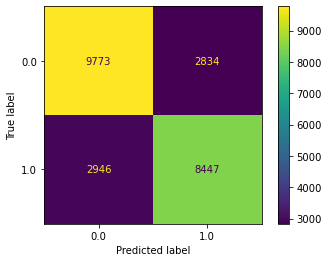

In [22]:
# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(gnb, X_test, y_test)
plt.show()

# Results Analysis
As we can see the accuracy when we assign 60% of the dataset to test and we use Naive Bayes model to predict the battle is around 75%, it means that we will predict correctly 3/4 of the battles.

According to the confusion matrix, as we can see In row 0 there are 12607 points, but only 9773 are correctly allocated to 0 and 2834 are incorrectly assigned to 1. In row 1 there are 11393 points, but only 8447 are correctly allocated to 1 and 2946 are incorrectly apportioned to 0. It seems that the model prediction fails a little more when we expect win.

## Part 4 (Optional) - Create an ensemble and configure the model

You have trained different classifiers but selected only one of them as "the best" one. Maybe instead of having the models competing between them, having them to colaborate would yield better results. 

We propose you to create an ensemble of the different classifiers explored in *Part 3*. You should compare the ensemble with the individual models using cross-validation, and then get the final accuracy and the confusion matrix for the ensemble.
As a bonus, try to tune the parameters of this ensemble using either `GridSearchCV` or `RandomizedSearchCV`.

1. Train an ensemble with the classifiers in *Part 3*.
2. Compare the performance of this ensemble using cross-validation, the final accuracy, and the confusion matrix. Analyze the results.
3. Fine-tune the hyper-parameters of the ensemble using `GridSearchCV` or `RandomizedSearchCV`.

In [23]:
# Ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

print("Decision Tree Classifier:\n")
tree_clf = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(tree_clf,X_train,y_train,cv=10)
tree_y_pred = tree_clf.fit(X_train,y_train).predict(X_test)

print(f"Cross_Validation: {scores} \n\nScores Mean: {scores.mean()}\n")
print(f"Final Accuracy: {accuracy_score(y_test, tree_y_pred)}\n")
print(confusion_matrix(y_test, tree_y_pred), ": is the confusion matrix")


Decision Tree Classifier:

Cross_Validation: [0.770625 0.75625  0.77875  0.75     0.748125 0.748125 0.739375 0.75125
 0.7525   0.779375] 

Scores Mean: 0.7574375

Final Accuracy: 0.7600416666666666

[[9798 2809]
 [2950 8443]] : is the confusion matrix


In [24]:
print("Random Forest Classifier:\n")
random_forest_clf = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(random_forest_clf,X_train,y_train,cv=10)
random_forest_y_pred = random_forest_clf.fit(X_train,y_train).predict(X_test)

print(f"Cross_Validation: {scores} \n\nScores Mean: {scores.mean()}\n")
print(f"Final Accuracy: {accuracy_score(y_test, random_forest_y_pred)}\n")
print(confusion_matrix(y_test, random_forest_y_pred), ": is the confusion matrix")

Random Forest Classifier:

Cross_Validation: [0.811875 0.81625  0.843125 0.798125 0.818125 0.82125  0.80375  0.811875
 0.814375 0.8125  ] 

Scores Mean: 0.8151250000000001

Final Accuracy: 0.8184166666666667

[[10892  1715]
 [ 2643  8750]] : is the confusion matrix


In [25]:
# https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318
print(f"Dimensions: {len(X.columns)}")

# Random search is the best parameter search technique when there are less number of dimensions.

Dimensions: 16


In [26]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_estimators=10)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

print(CV_rfc.best_params_)


{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


As we can see, when we use an ensemble model the accuracy is better than the simple model, it is because the goal of ensemble methods is to combine the predictions of several base estimators, built with a given learning algorithm in order to improve generalizability / robustness over a single estimator. 

For this reason, when we use the Decision Tree Classifier it has around 73% of accuracy and the Random Forest Classifier it has around 79% of accuracy. Also, Random forest classifier is useful because:
- No overfitting
- High accuracy
- Estimates missing data

## Part 5 - Wrap-up (2 points)
The final part of this assignment is to wrap-up your classifier into a pipeline. This pipeline will execute the entire process:

- Preprocess the data
    - Select features
    - Impute data
    - Encode values
- The classifier selected in *Part 3* (or the ensemble if it is better)

This pipeline will be used in the other provided notebook to generate the predictions for the combats you have to submit.

To ensure everything works as expected, we recommend you to load the dataset again before using it with the pipeline. You should also compare the accuracy and the confusion matrix from the pipeline with the model trained before. **Remember to set the random state to all the required transformers and estimators to have a constant output**.

In [27]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

processing_df = data
processing_df['Wins'] = processing_df['Wins'].astype('Int64')
processing_df = processing_df.drop(columns=['Legendary', 'Legendary__other','Generation','Generation__other','Type 2','Type 2__other'])

cat = ['Name','Name__other','Type 1','Type 1__other']
num = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed','HP__other', 'Attack__other', 'Defense__other', 'Sp. Atk__other', 'Sp. Def__other', 'Speed__other']

clf = Pipeline(
    steps=[
        ("encode", ColumnTransformer(transformers=[
            ("cat_name", OneHotEncoder(sparse=False, handle_unknown = 'ignore'), cat)
        ],remainder='passthrough')),
        ("imputer", KNNImputer(n_neighbors=1)),
        ("classifier", GaussianNB())
])

In [28]:
X, y = get_Xy(processing_df) # X = features , y = target (Win/Loss)

y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

y_pred = clf.fit(X_train,y_train).predict(X_test)

In [29]:
print(confusion_matrix(y_test, y_pred), ": is the confusion matrix")

[[9379 3228]
 [2195 9198]] : is the confusion matrix


In [30]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7740416666666666


First of all, the wrap-up has a little difference from the original development. The difference is that we drop all the useless columns before the KNN imputation. For this reason, the accuracy from the original is lower than the wrap-up.

Original Accuracy : 75.91%
Wrap-up Accuracy: 77.40%

The wrap-up improves the prediction in the fourth quadrant in the confusion matrix. However, that improvement it is not important to conclude if this method is better than the original way, because the other quadrants are worse and the final accuracy is also better than original.
